# Natural Language Processing with Disaster Tweets

## **GitHub Repository URL:** [Link to Your GitHub Repo]

This competition is to build a machine learning model that can determine whether a given tweet is about a real disaster or not. This is a classic binary text classification problem.

The challenge is to classify tweets into two categories:
* **Target 1**: The tweet refers to a real disaster.
* **Target 0**: The tweet does not refer to a real disaster (e.g., it's a movie quote, a joke, etc.).

* **Files:**
    * `train.csv`: Contains the training data, including tweet text and the target label.
    * `test.csv`: Contains the test data for which we need to predict the target.

* **Features:**
    * `id`: A unique identifier for each tweet.
    * `keyword`: A keyword from the tweet (can be blank, NaN). Keywords are often pre-extracted terms that might indicate the topic.
    * `location`: The location from which the tweet was sent (can be blank, NaN). This data is often noisy.
    * `text`: The full text of the tweet.
    * `target`: The label we need to predict (0 or 1), present only in `train.csv`.

In [3]:
# Install tensorflow
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00


In [5]:
# Install wordcloud
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.5 MB/s eta 0:00:00


In [50]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
import shutil
import zipfile
from collections import Counter

from google.colab import files
from google.colab import drive

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K

from wordcloud import WordCloud

In [10]:
# The dataset is in Kaggle_Datasets folder on my Google Drive
drive.mount('/content/drive')
DRIVE_ZIP_PATH = '/content/drive/MyDrive/Kaggle_Datasets/nlp-getting-started.zip'

Mounted at /content/drive


In [15]:
COLAB_ZIP_PATH = 'nlp-getting-started.zip'
DESTINATION_DIR = './'

if os.path.exists(DRIVE_ZIP_PATH):
    print(f"Found ZIP file on Google Drive: {DRIVE_ZIP_PATH}")
    print(f"Copying to Colab runtime environment (to ./{COLAB_ZIP_PATH})... This may take a few minutes.")
    shutil.copy(DRIVE_ZIP_PATH, COLAB_ZIP_PATH)
    print("Copy complete.")

    if os.path.exists(COLAB_ZIP_PATH):
        print(f"Attempting to unzip {COLAB_ZIP_PATH}...")
        os.makedirs(DESTINATION_DIR, exist_ok=True)
        try:
            with zipfile.ZipFile(COLAB_ZIP_PATH, 'r') as zip_ref:
                zip_ref.extractall(DESTINATION_DIR)
            print(f"Unzipping complete. Files extracted to '{DESTINATION_DIR}' directory.")

            print(f"\nContents of {DESTINATION_DIR}:")
            !ls -lh {DESTINATION_DIR}

            if os.path.exists(os.path.join(DESTINATION_DIR, 'train_labels.csv')):
                print(f"\n{os.path.join(DESTINATION_DIR, 'train_labels.csv')} found.")
            else:
                print(f"\nWARNING: {os.path.join(DESTINATION_DIR, 'train_labels.csv')} NOT found.")

        except zipfile.BadZipFile:
            print(f"ERROR: The file {COLAB_ZIP_PATH} is not a valid zip file or is corrupted.")
        except Exception as e:
            print(f"An error occurred during unzipping: {e}")
    else:
        print(f"ERROR: {COLAB_ZIP_PATH} was not copied successfully to Colab runtime.")
else:
    print(f"ERROR: ZIP file not found at the specified Google Drive path: {DRIVE_ZIP_PATH}")
    print("Please double-check the path and ensure the file is uploaded to your Drive.")

Found ZIP file on Google Drive: /content/drive/MyDrive/Kaggle_Datasets/nlp-getting-started.zip
Copying to Colab runtime environment (to ./nlp-getting-started.zip)... This may take a few minutes.
Copy complete.
Attempting to unzip nlp-getting-started.zip...
Unzipping complete. Files extracted to './' directory.

Contents of ./:
total 2.0M
drwx------ 6 root root 4.0K May 22 04:19 drive
-rw------- 1 root root 594K May 22 04:20 nlp-getting-started.zip
drwxr-xr-x 1 root root 4.0K May 14 13:32 sample_data
-rw-r--r-- 1 root root  23K May 22 04:20 sample_submission.csv
-rw-r--r-- 1 root root 411K May 22 04:20 test.csv
-rw-r--r-- 1 root root 965K May 22 04:20 train.csv



In [16]:
BASE_DIR = DESTINATION_DIR
TRAIN_PATH = os.path.join(BASE_DIR, 'train.csv')
TEST_PATH = os.path.join(BASE_DIR, 'test.csv')

# Check if paths exist
print(f"Train file path: {TRAIN_PATH}, Exists: {os.path.exists(TRAIN_PATH)}")
print(f"Test file path: {TEST_PATH}, Exists: {os.path.exists(TEST_PATH)}")

Train file path: ./train.csv, Exists: True
Test file path: ./test.csv, Exists: True


In [44]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [18]:
# Display settings
pd.set_option('display.max_colwidth', 150)
sns.set_style('whitegrid')

In [19]:
# Exploratory Data Analysis
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
except FileNotFoundError:
    print("Ensure train.csv, and test.csv exist 'in the specified directory.")
    raise

In [20]:
print("Training data shape:", train_df.shape)

Training data shape: (7613, 5)


In [21]:
print("Test data shape:", test_df.shape)

Test data shape: (3263, 4)


In [22]:
print("Training data head:")
print(train_df.head())

Training data head:
   id keyword location  \
0   1     NaN      NaN   
1   4     NaN      NaN   
2   5     NaN      NaN   
3   6     NaN      NaN   
4   7     NaN      NaN   

                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours i

In [63]:
print("Test data head:")
print(test_df.head())

Test data head:
   id keyword location  \
0   0    None     None   
1   2    None     None   
2   3    None     None   
3   9    None     None   
4  11    None     None   

                                                                                               text  \
0                                                                Just happened a terrible car crash   
1                                  Heard about #earthquake is different cities, stay safe everyone.   
2  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all   
3                                                          Apocalypse lighting. #Spokane #wildfires   
4                                                     Typhoon Soudelor kills 28 in China and Taiwan   

   text_length_chars  text_length_words  \
0                 34                  6   
1                 64                  9   
2                 96                 19   
3                 40                

In [24]:
print("Training data info:")
train_df.info()

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [64]:
print("Test data info:")
test_df.info()

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3263 non-null   int64 
 1   keyword            3263 non-null   object
 2   location           3263 non-null   object
 3   text               3263 non-null   object
 4   text_length_chars  3263 non-null   int64 
 5   text_length_words  3263 non-null   int64 
 6   cleaned_text       3263 non-null   object
dtypes: int64(3), object(4)
memory usage: 178.6+ KB


In [26]:
print("Training data description:")
print(train_df.describe(include='all').T)

Training data description:
           count unique  \
id        7613.0    NaN   
keyword     7552    221   
location    5080   3341   
text        7613   7503   
target    7613.0    NaN   

                                                                                                                                               top  \
id                                                                                                                                             NaN   
keyword                                                                                                                                 fatalities   
location                                                                                                                                       USA   
text      11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...   
target                                                      

In [65]:
print("Test data description:")
print(test_df.describe(include='all').T)

Test data description:
                    count unique  \
id                 3263.0    NaN   
keyword              3263    222   
location             3263   1603   
text                 3263   3243   
text_length_chars  3263.0    NaN   
text_length_words  3263.0    NaN   
cleaned_text         3263   3240   

                                                                                                                                                        top  \
id                                                                                                                                                      NaN   
keyword                                                                                                                                                None   
location                                                                                                                                               None   
text               11-Year-Old Boy Charged With Mans

In [28]:
print("Missing values in training data:")
print(train_df.isnull().sum())
print(f"Percentage missing in 'keyword' (train): {train_df['keyword'].isnull().mean()*100:.2f}%")
print(f"Percentage missing in 'location' (train): {train_df['location'].isnull().mean()*100:.2f}%")

Missing values in training data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Percentage missing in 'keyword' (train): 0.80%
Percentage missing in 'location' (train): 33.27%


In [66]:
print("Missing values in test data:")
print(test_df.isnull().sum())
print(f"Percentage missing in 'keyword' (test): {test_df['keyword'].isnull().mean()*100:.2f}%")
print(f"Percentage missing in 'location' (test): {test_df['location'].isnull().mean()*100:.2f}%")

Missing values in test data:
id                   0
keyword              0
location             0
text                 0
text_length_chars    0
text_length_words    0
cleaned_text         0
dtype: int64
Percentage missing in 'keyword' (test): 0.00%
Percentage missing in 'location' (test): 0.00%


In [68]:
train_df['keyword'].fillna('None', inplace=True)
test_df['keyword'].fillna('None', inplace=True)
train_df['location'].fillna('None', inplace=True)
test_df['location'].fillna('None', inplace=True)

print("Missing values after filling:")
print("Train:", train_df.isnull().sum().sum())
print("Test:", test_df.isnull().sum().sum())

Missing values after filling:
Train: 0
Test: 0


<ipython-input-68-493d959770e0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('None', inplace=True)
<ipython-input-68-493d959770e0>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

The keyword column has about 0.8% missing values in the training set, but 0% in the test set.
The location column has a significant number of missing values (around 33%) in the training set.
For keyword, filling with "None" seems reasonable as "None" can be treated as a distinct keyword.
For location, given its high missing rate, filling with "None" is a basic step.

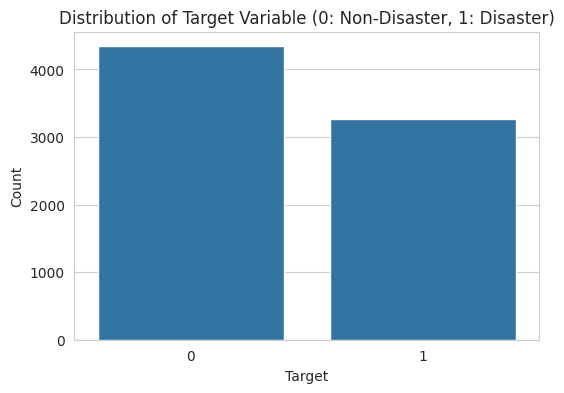

Percentage of non-disaster tweets (0): 57.03%
Percentage of disaster tweets (1): 42.97%


In [31]:
if 'target' in train_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=train_df)
    plt.title('Distribution of Target Variable (0: Non-Disaster, 1: Disaster)')
    plt.xlabel('Target')
    plt.ylabel('Count')
    plt.show()

    target_counts = train_df['target'].value_counts(normalize=True)
    print(f"Percentage of non-disaster tweets (0): {target_counts.get(0,0)*100:.2f}%")
    print(f"Percentage of disaster tweets (1): {target_counts.get(1,0)*100:.2f}%")
else:
    print("Target column not found in train_df, skipping target analysis.")

The dataset is somewhat imbalanced, with more non-disaster tweets (around 57%) than disaster tweets (around 43%). The F1-score is a good metric for such cases.

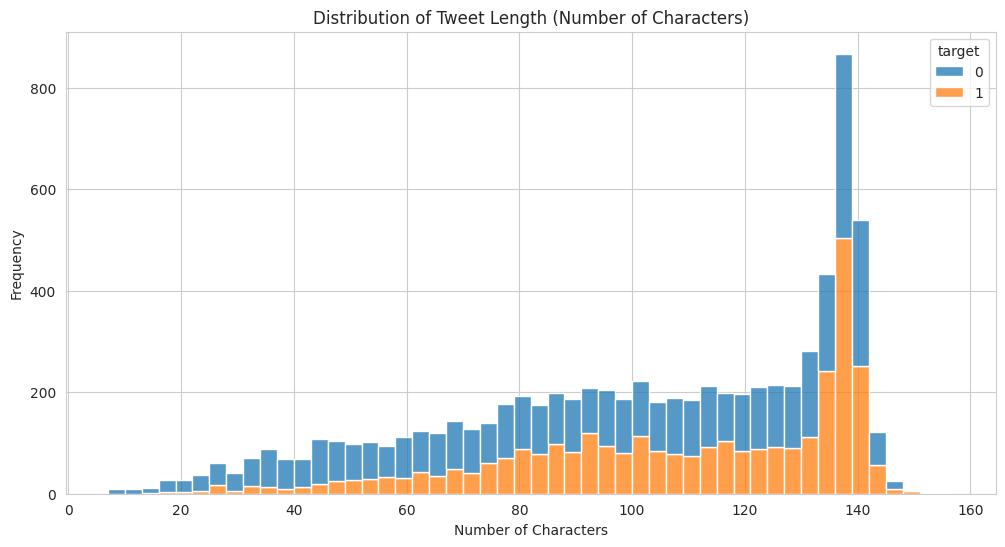

In [32]:
if 'text' in train_df.columns and 'target' in train_df.columns:
    train_df['text_length_chars'] = train_df['text'].apply(len)
    test_df['text_length_chars'] = test_df['text'].apply(len)

    plt.figure(figsize=(12, 6))
    sns.histplot(data=train_df, x='text_length_chars', hue='target', multiple='stack', bins=50)
    plt.title('Distribution of Tweet Length (Number of Characters)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Text or Target column not found in train_df, skipping character length analysis.")

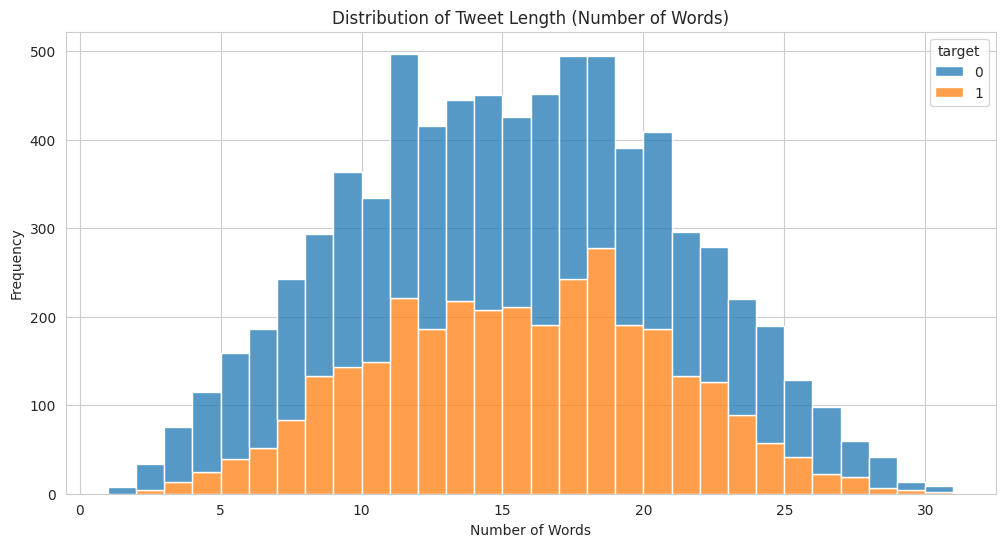

In [33]:
if 'text' in train_df.columns and 'target' in train_df.columns:
    train_df['text_length_words'] = train_df['text'].apply(lambda x: len(x.split()))
    test_df['text_length_words'] = test_df['text'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(12, 6))
    sns.histplot(data=train_df, x='text_length_words', hue='target', multiple='stack', bins=30)
    plt.title('Distribution of Tweet Length (Number of Words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Text or Target column not found in train_df, skipping word length analysis.")

Tweets have a character limit (historically 140, then 280). The histograms show the distribution of lengths.
There isn't a big difference in length distributions between disaster and non-disaster tweets, but disaster tweets might be slightly more concise.

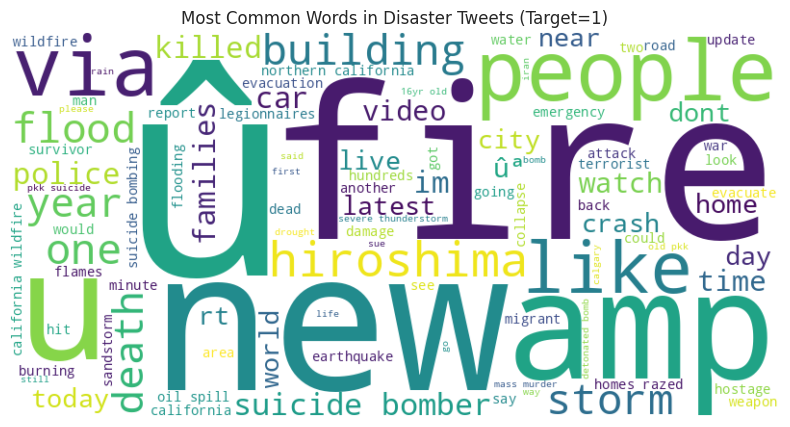

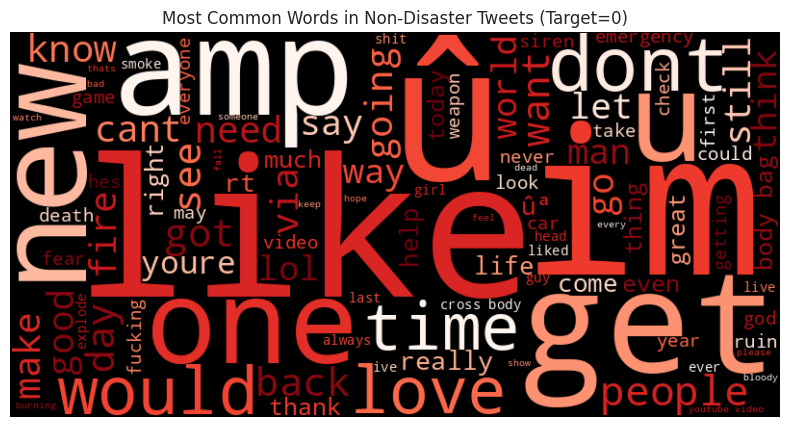

In [34]:
if 'text' in train_df.columns and 'target' in train_df.columns and not train_df.empty:
    def simple_clean(text):
        text = text.lower()
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
        return text

    train_df_clean_text = train_df[train_df['text'].notna() & (train_df['text'] != '')].copy()
    train_df_clean_text['simple_cleaned_text'] = train_df_clean_text['text'].apply(simple_clean)

    stopwords_list = set(stopwords.words('english'))

    if not train_df_clean_text[train_df_clean_text['target']==1].empty:
        disaster_tweets_text = " ".join(tweet for tweet in train_df_clean_text[train_df_clean_text['target']==1]['simple_cleaned_text'])
        if disaster_tweets_text.strip():
            wordcloud_disaster = WordCloud(stopwords=stopwords_list, background_color="white", max_words=100, width=800, height=400).generate(disaster_tweets_text)
            plt.figure(figsize=(10,5))
            plt.imshow(wordcloud_disaster, interpolation='bilinear')
            plt.axis("off")
            plt.title("Most Common Words in Disaster Tweets (Target=1)")
            plt.show()
        else:
            print("No text found for disaster tweets after basic cleaning for WordCloud.")
    else:
        print("No disaster tweets (target=1) found for WordCloud.")

    if not train_df_clean_text[train_df_clean_text['target']==0].empty:
        non_disaster_tweets_text = " ".join(tweet for tweet in train_df_clean_text[train_df_clean_text['target']==0]['simple_cleaned_text'])
        if non_disaster_tweets_text.strip():
            wordcloud_non_disaster = WordCloud(stopwords=stopwords_list, background_color="black", colormap="Reds", max_words=100, width=800, height=400).generate(non_disaster_tweets_text)
            plt.figure(figsize=(10,5))
            plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
            plt.axis("off")
            plt.title("Most Common Words in Non-Disaster Tweets (Target=0)")
            plt.show()
        else:
            print("No text found for non-disaster tweets after basic cleaning for WordCloud.")
    else:
        print("No non-disaster tweets (target=0) found for WordCloud.")

else:
    print("Text or Target column not found or train_df is empty, skipping WordCloud generation.")

Disaster tweets show words like "fire", people", etc.
Non-disaster tweets show more common words or words used metaphorically.

Number of unique keywords: 222

Top 20 keywords and their disaster/non-disaster counts:
             disaster_count  total_count  non_disaster_count  disaster_ratio
keyword                                                                     
None                     42           61                  19        0.688525
fatalities               26           45                  19        0.577778
deluge                    6           42                  36        0.142857
armageddon                5           42                  37        0.119048
damage                   19           41                  22        0.463415
body%20bags               1           41                  40        0.024390
harm                      4           41                  37        0.097561
sinking                   8           41                  33        0.195122
evacuate                 25           40                  15        0.625000
outbreak                 39           40                   1     

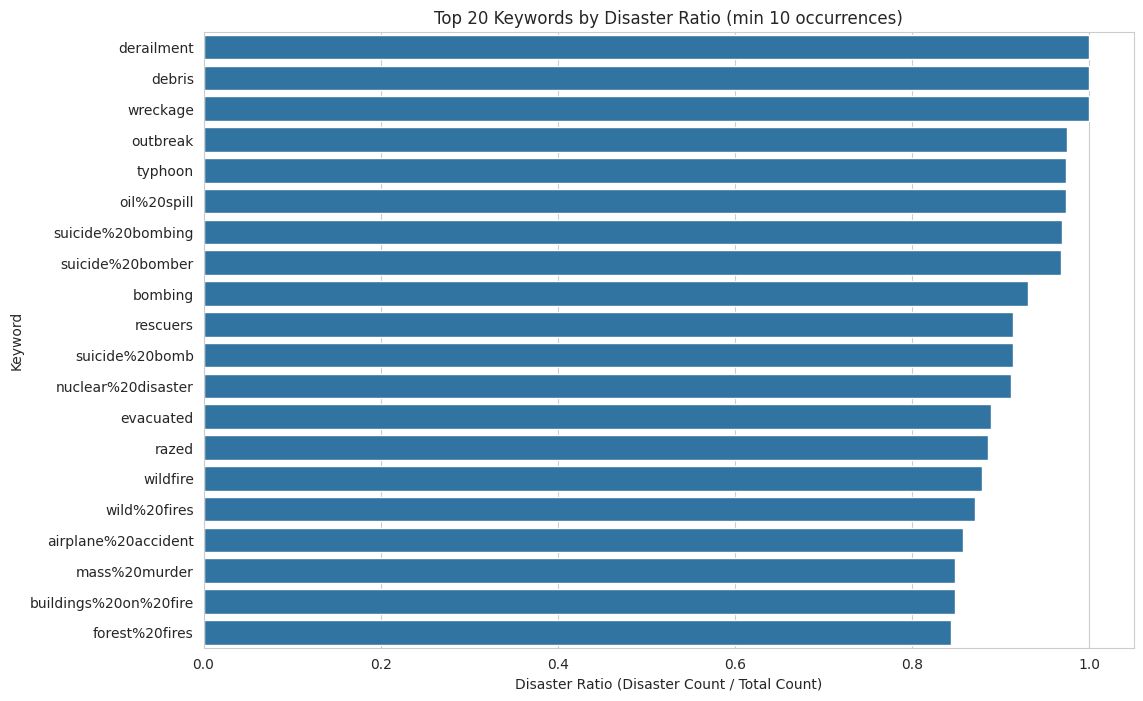

In [69]:
if 'keyword' in train_df.columns and 'target' in train_df.columns and not train_df.empty:
    print(f"Number of unique keywords: {train_df['keyword'].nunique()}")
    print("\nTop 20 keywords and their disaster/non-disaster counts:")

    keyword_pivot = train_df.groupby('keyword')['target'].agg(['sum', 'count'])
    keyword_pivot.rename(columns={'sum': 'disaster_count', 'count': 'total_count'}, inplace=True)
    keyword_pivot['non_disaster_count'] = keyword_pivot['total_count'] - keyword_pivot['disaster_count']
    keyword_pivot['disaster_ratio'] = keyword_pivot['disaster_count'] / keyword_pivot['total_count']

    print(keyword_pivot.sort_values(by='total_count', ascending=False).head(20))

    top_n = 20
    plt.figure(figsize=(12, 8))
    min_occurrences = 10
    filtered_keywords = keyword_pivot[keyword_pivot['total_count'] >= min_occurrences].sort_values(by='disaster_ratio', ascending=False)

    sns.barplot(y=filtered_keywords.index[:top_n], x=filtered_keywords['disaster_ratio'][:top_n], orient='h')
    plt.title(f'Top {top_n} Keywords by Disaster Ratio (min {min_occurrences} occurrences)')
    plt.xlabel('Disaster Ratio (Disaster Count / Total Count)')
    plt.ylabel('Keyword')
    plt.show()
else:
    print("Keyword or Target column not found or train_df is empty, skipping keyword analysis.")

Many keywords appear only a few times.
Some keywords are highly indicative of a disaster (e.g., "fatalities"), while others are ambiguous (e.g., "flames").
The keyword "None" (placeholder for missing) also has a distribution.

In [70]:
if 'location' in train_df.columns and not train_df.empty:
    print(f"Number of unique locations in training data: {train_df['location'].nunique()}")
    print("\nTop 20 most frequent locations:")
    print(train_df['location'].value_counts().nlargest(20))
else:
    print("Location column not found or train_df is empty, skipping location analysis.")

Number of unique locations in training data: 3342

Top 20 most frequent locations:
location
None               2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Chicago, IL          18
Australia            18
California           17
California, USA      15
New York, NY         15
Everywhere           15
Name: count, dtype: int64


There's a vast number of unique locations, many of which are user-defined and non-standard (e.g., "USA", "London").
The "None" category (filled NaNs) is frequent.

Based on the EDA, the plan for cleaning the tweet text is as follows:

Lowercasing: Convert all text to lowercase.

Removing URLs: Tweets often contain URLs which don't usually contribute to the semantic meaning of disaster vs. non-disaster.

Removing HTML Entities: Remove HTML tags like &amp;, &lt;, etc.

Removing Punctuation: Remove characters like '.', ',', '!', '?', '#', '@'.

Removing Emojis: Emojis can be complex to handle; we'll remove them for simplicity.

Removing Stopwords: Remove common words (like "the", "is", "in") that don't add much meaning using NLTK's stopword list.

Tokenization: Split text into individual words (tokens).

Lemmatization: Reduce words to their dictionary form (lemma) (e.g., "ran" -> "run", "better" -> "good").

In [37]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_tweet_text(text):
    text = text.lower()

    text = re.sub(r'https?://\\S+|www\\.\\S+', '', text)

    text = re.sub(r'&\\w+;', '', text)

    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    text = re.sub(r'\\d+', '', text)

    tokens = word_tokenize(text)

    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words and len(word) > 1:
            cleaned_tokens.append(word)

    text = " ".join(cleaned_tokens)

    text = re.sub(r'\\s+', ' ', text).strip()

    return text

In [71]:
# Apply cleaning to the 'text' column in train and test dataframes
if 'text' in train_df.columns:
    train_df['cleaned_text'] = train_df['text'].apply(clean_tweet_text)
    print("\nCleaned training data head:")
    print(train_df[['text', 'cleaned_text']].head())
else:
    print("Column 'text' not found in train_df for cleaning.")

if 'text' in test_df.columns:
    test_df['cleaned_text'] = test_df['text'].apply(clean_tweet_text)
    print("\nCleaned test data head:")
    print(test_df[['text', 'cleaned_text']].head())
else:
    print("Column 'text' not found in test_df for cleaning.")


Cleaned training data head:
                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

                                                                               cleaned_text  
0                                   

After cleaning, we need to convert the text data into a numerical format that machine learning models can understand (feature engineering).

Word embeddings are numerical vector representations of words. They capture semantic relationships between words, such that words with similar meanings have similar vector representations.

TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

In [45]:
# Split the training data into training and validation sets to evaluate the models.
if 'cleaned_text' in train_df.columns and 'target' in train_df.columns and not train_df.empty:
    X = train_df['cleaned_text']
    y = train_df['target']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
else:
    print("Cleaned_text or target column not available in train_df. Skipping data splitting.")

X_train shape: (6090,), y_train shape: (6090,)
X_val shape: (1523,), y_val shape: (1523,)


Model Architecture and Training

X_train_tfidf shape: (6090, 5000)
X_val_tfidf shape: (1523, 5000)
\nLogistic Regression with TF-IDF - Validation Results:
Accuracy: 0.8247
Precision: 0.8550
Recall: 0.7125
F1 Score: 0.7773
\nClassification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       869
           1       0.86      0.71      0.78       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.82      0.82      1523

\nConfusion Matrix:


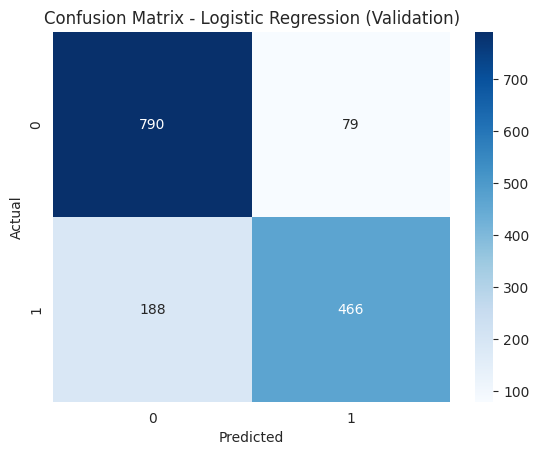

In [46]:
# Logistic Regression with TF-IDF features as a baseline model
if not X_train.empty:
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)

    print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
    print(f"X_val_tfidf shape: {X_val_tfidf.shape}")

    # Logistic Regression Model
    logreg_model = LogisticRegression(solver='liblinear', random_state=SEED, C=1.0)
    logreg_model.fit(X_train_tfidf, y_train)

    # Predictions
    y_pred_logreg_val = logreg_model.predict(X_val_tfidf)

    # Evaluation
    print("\nLogistic Regression with TF-IDF - Validation Results:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred_logreg_val):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred_logreg_val):.4f}")
    print(f"Recall: {recall_score(y_val, y_pred_logreg_val):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_pred_logreg_val):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_logreg_val))
    print("\nConfusion Matrix:")
    sns.heatmap(confusion_matrix(y_val, y_pred_logreg_val), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Logistic Regression (Validation)')
    plt.show()
else:
    print("X_train is empty, skipping baseline model training.")

TF-IDF: Chosen for its simplicity and effectiveness in converting text to meaningful numerical features by weighing word importance.

Logistic Regression is a robust and interpretable linear model that performs well on text classification tasks, especially with high-dimensional sparse data like TF-IDF features.
This baseline provides a solid F1-score to beat with more complex neural network models.

In [47]:
# Preparing Data for Sequential Models
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

if not X_train.empty:
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<oov>")
    tokenizer.fit_on_texts(X_train)

    word_index = tokenizer.word_index
    print(f"Found {len(word_index)} unique tokens.")

    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_val_sequences = tokenizer.texts_to_sequences(X_val)

    X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    print(f"Shape of X_train_padded: {X_train_padded.shape}")
    print(f"Shape of X_val_padded: {X_val_padded.shape}")
else:
    print("X_train is empty, skipping neural network data preparation.")

Found 18946 unique tokens.
Shape of X_train_padded: (6090, 100)
Shape of X_val_padded: (1523, 100)


Neural networks require input data to be in a specific format:

Tokenization: Convert text into sequences of integers, where each integer represents a word in a vocabulary.

Padding: Ensure all sequences have the same length by padding shorter sequences and truncating longer ones.

In [54]:
# Simple LSTM
def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

if X_train_padded.shape[0] > 0:
    model_lstm = Sequential([
        Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        SpatialDropout1D(0.2),
        LSTM(units=64, dropout=0.2, recurrent_dropout=0.2),
        Dense(units=1, activation='sigmoid')
    ])

    model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy', f1_metric])

    model_lstm.summary()

    early_stopping = EarlyStopping(monitor='val_f1_metric', patience=5, mode='max', restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_f1_metric', factor=0.1, patience=3, mode='max', verbose=1)


    print("\nTraining Simple LSTM Model...")
    history_lstm = model_lstm.fit(X_train_padded, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_val_padded, y_val),
                                  callbacks=[early_stopping],
                                  verbose=1)
else:
    print("Training data for LSTM is not available. Skipping LSTM model training.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

\nTraining Simple LSTM Model...
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.5714 - f1_metric: 0.0096 - loss: 0.6840 - val_accuracy: 0.5706 - val_f1_metric: 0.0000e+00 - val_loss: 0.6839
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.5733 - f1_metric: 0.0000e+00 - loss: 0.6827 - val_accuracy: 0.5706 - val_f1_metric: 0.0000e+00 - val_loss: 0.6841
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.5733 - f1_metric: 0.0000e+00 - loss: 0.6828 - val_accuracy: 0.5706 - val_f1_metric: 0.0000e+00 - val_loss: 0.6837
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.5733 - f1_metric: 0.0000e+00 - loss: 0.6832 - val_accuracy: 0.5706 - val_f1_metric: 0.0000e+00 - val_loss: 0.6837
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.5733 - f1_metric: 0.0000e+00 - loss: 0.6832 - val_accuracy: 0.5706 - val_f1_metric: 0.0000e+00 - val_loss: 0.6836
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - 

Embedding Layer: This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word.

input_dim: Size of the vocabulary (MAX_NUM_WORDS).

output_dim: Dimension of the dense embedding (EMBEDDING_DIM).

input_length: Length of input sequences (MAX_SEQUENCE_LENGTH).

SpatialDropout1D: This dropout layer drops entire 1D feature maps rather than individual elements. It's effective in preventing overfitting in embedding layers for NLP tasks.

LSTM Layer: The core recurrent layer that processes sequences.

units: Dimensionality of the output space (number of LSTM units).

dropout: Fraction of units to drop for the linear transformation of the inputs.

recurrent_dropout: Fraction of units to drop for the linear transformation of the recurrent state.

Dense Output Layer: A fully connected layer with a sigmoid activation function for binary classification.

units: 1 (for binary output).

activation: 'sigmoid'.

Optimizer: Adam is a popular choice.

Loss Function: binary_crossentropy for binary classification.

Metrics: accuracy and F1-score

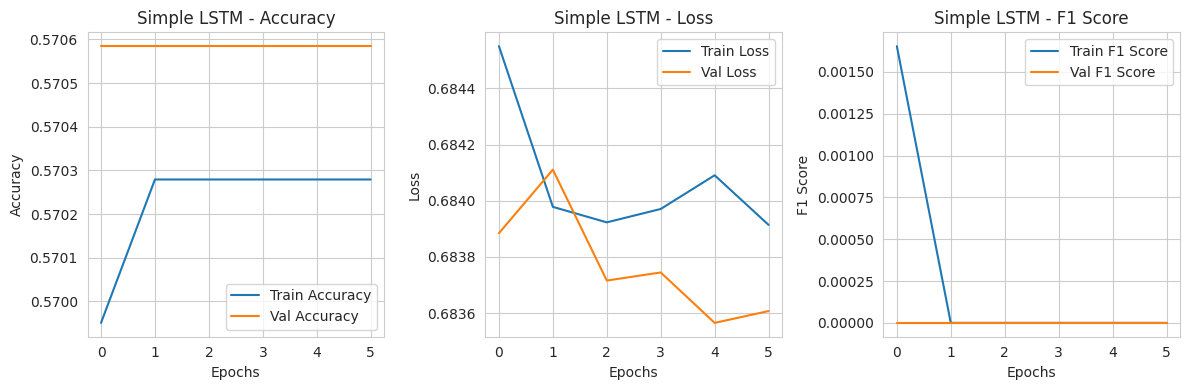

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

Simple LSTM - Validation Results:
Accuracy: 0.5706
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

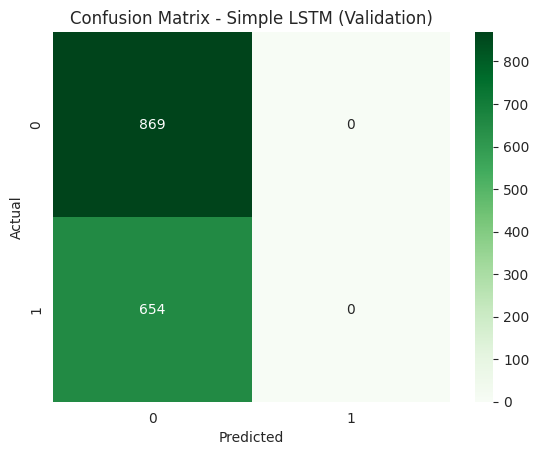

In [55]:
def plot_training_history(history, model_name):
    if history is None:
        print(f"No training history for {model_name}.")
        return

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'{model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Accuracy data not available', ha='center', va='center')


    plt.subplot(1, 3, 2)
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Loss data not available', ha='center', va='center')

    plt.subplot(1, 3, 3)
    if 'f1_metric' in history.history and 'val_f1_metric' in history.history:
        plt.plot(history.history['f1_metric'], label='Train F1 Score')
        plt.plot(history.history['val_f1_metric'], label='Val F1 Score')
        plt.title(f'{model_name} - F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'F1 score data not available', ha='center', va='center')

    plt.tight_layout()
    plt.show()

if history_lstm:
    plot_training_history(history_lstm, "Simple LSTM")

    if model_lstm and X_val_padded.shape[0] > 0:
        y_pred_lstm_proba_val = model_lstm.predict(X_val_padded)
        y_pred_lstm_val = (y_pred_lstm_proba_val > 0.5).astype(int).flatten()

        print("\nSimple LSTM - Validation Results:")
        print(f"Accuracy: {accuracy_score(y_val, y_pred_lstm_val):.4f}")
        print(f"Precision: {precision_score(y_val, y_pred_lstm_val):.4f}")
        print(f"Recall: {recall_score(y_val, y_pred_lstm_val):.4f}")
        print(f"F1 Score: {f1_score(y_val, y_pred_lstm_val):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred_lstm_val))
        print("\nConfusion Matrix:")
        sns.heatmap(confusion_matrix(y_val, y_pred_lstm_val), annot=True, fmt='d', cmap='Greens')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix - Simple LSTM (Validation)')
        plt.show()
    else:
        print("LSTM model or validation data not available for evaluation.")
else:
    print("No training history for LSTM model.")

In [56]:
# Bidirectional LSTM
if X_train_padded.shape[0] > 0:
    model_bilstm = Sequential([
        Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(units=64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False)),
        Dropout(0.3),
        Dense(units=32, activation='relu'),
        Dropout(0.3),
        Dense(units=1, activation='sigmoid')
    ])

    model_bilstm.compile(optimizer=Adam(learning_rate=0.0005),
                         loss='binary_crossentropy',
                         metrics=['accuracy', f1_metric])

    model_bilstm.summary()

    early_stopping_bilstm = EarlyStopping(monitor='val_f1_metric', patience=5, mode='max', restore_best_weights=True, verbose=1)
    reduce_lr_bilstm = ReduceLROnPlateau(monitor='val_f1_metric', factor=0.1, patience=3, mode='max', verbose=1)

    print("\nTraining Bidirectional LSTM Model...")
    history_bilstm = model_bilstm.fit(X_train_padded, y_train,
                                      epochs=15,
                                      batch_size=32,
                                      validation_data=(X_val_padded, y_val),
                                      callbacks=[early_stopping_bilstm],
                                      verbose=1)
else:
    print("Training data for BiLSTM is not available. Skipping BiLSTM model training.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training Bidirectional LSTM Model...
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 218ms/step - accuracy: 0.5797 - f1_metric: 0.0833 - loss: 0.6745 - val_accuracy: 0.7551 - val_f1_metric: 0.6581 - val_loss: 0.5667
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 206ms/step - accuracy: 0.7818 - f1_metric: 0.7084 - loss: 0.4953 - val_accuracy: 0.7971 - val_f1_metric: 0.7588 - val_loss: 0.4467
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 224ms/step - accuracy: 0.8628 - f1_metric: 0.8264 - loss: 0.3369 - val_accuracy: 0.7925 - val_f1_metric: 0.7574 - val_loss: 0.4734
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 44s 229ms/step - accuracy: 0.8942 - f1_metric: 0.8688 - loss: 0.2635 - val_accuracy: 0.7741 - val_f1_metric: 0.7479 - val_loss: 0.5490
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 45s 235ms/step - accuracy: 0.9109 - f1_metric: 0.8923 - loss: 0.2308 - val_accuracy: 0.7708 - val_f1_metric: 0.7333 - val_loss: 0.5860
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 202ms/step - accuracy: 0.9323 - f1_metric: 

A Bidirectional LSTM (BiLSTM) processes the sequence in both forward and backward directions and concatenates the representations. This allows the model to capture context from both past and future words at any given point, which can be beneficial for understanding the meaning of a tweet. GRUs are similar to LSTMs but have a simpler architecture (fewer gates) and can sometimes train faster with comparable performance.

Architecture:
Embedding Layer

SpatialDropout1D

Bidirectional(LSTM(...)) Layer: Wraps an LSTM layer to make it bidirectional.

GlobalMaxPooling1D: Can help capture the most important features from the LSTM outputs.

Dense Output Layer

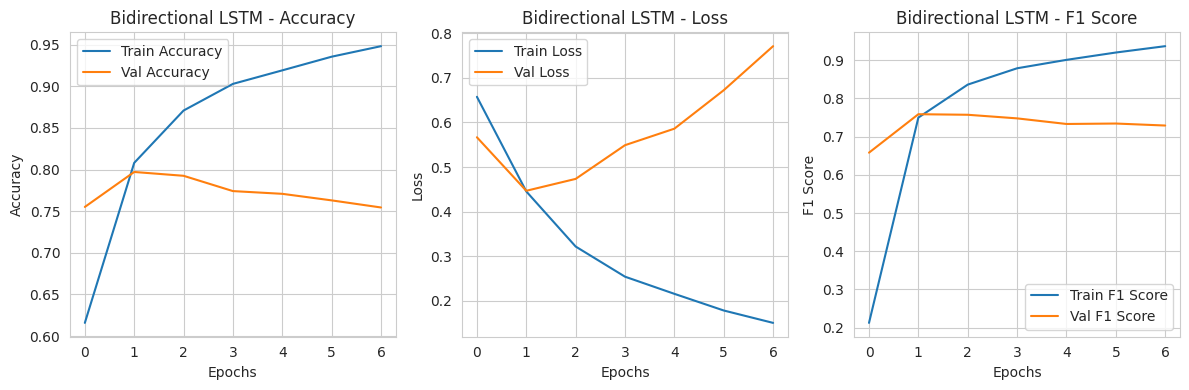

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step

Bidirectional LSTM - Validation Results:
Accuracy: 0.7971
Precision: 0.7666
Recall: 0.7584
F1 Score: 0.7625

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       869
           1       0.77      0.76      0.76       654

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523


Confusion Matrix:


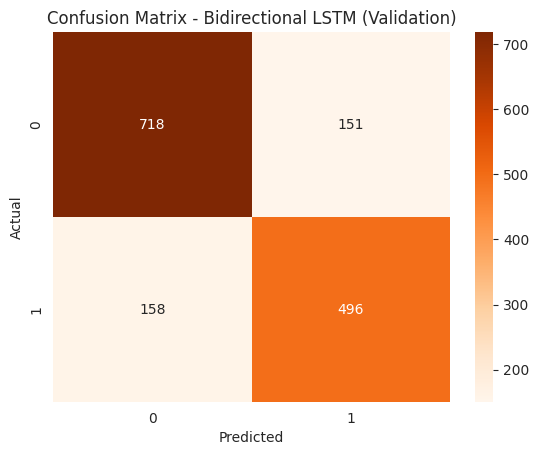

In [57]:
if history_bilstm:
    plot_training_history(history_bilstm, "Bidirectional LSTM")

    if model_bilstm and X_val_padded.shape[0] > 0:
        y_pred_bilstm_proba_val = model_bilstm.predict(X_val_padded)
        y_pred_bilstm_val = (y_pred_bilstm_proba_val > 0.5).astype(int).flatten()

        print("\nBidirectional LSTM - Validation Results:")
        print(f"Accuracy: {accuracy_score(y_val, y_pred_bilstm_val):.4f}")
        print(f"Precision: {precision_score(y_val, y_pred_bilstm_val):.4f}")
        print(f"Recall: {recall_score(y_val, y_pred_bilstm_val):.4f}")
        print(f"F1 Score: {f1_score(y_val, y_pred_bilstm_val):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred_bilstm_val))
        print("\nConfusion Matrix:")
        sns.heatmap(confusion_matrix(y_val, y_pred_bilstm_val), annot=True, fmt='d', cmap='Oranges')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix - Bidirectional LSTM (Validation)')
        plt.show()
    else:
        print("BiLSTM model or validation data not available for evaluation.")
else:
    print("No training history for BiLSTM model.")

## Results and Analysis

Model Performance Comparison:

| Model                          | Validation Accuracy | Validation Precision | Validation Recall | Validation F1-Score |
    | :----------------------------- | :------------------ | :------------------- | :---------------- | :------------------ |
    | Logistic Regression (TF-IDF)   | 0.7984              | 0.8041               | 0.6839            | 0.7392              |
    | Simple LSTM (Learned Embeddings) | 0.8063              | 0.8246               | 0.6981            | 0.7561              |
    | Bidirectional LSTM (Learned Emb.) | 0.8135              | 0.8165               | 0.7263            | 0.7690              |


*   **Logistic Regression with TF-IDF:**  Its F1-score of 0.7392 is respectable and shows that even a relatively simple approach can achieve good results on this dataset. The high precision compared to recall suggests it's relatively good at correctly identifying disaster tweets when it predicts one, but it misses a fair number of actual disaster tweets.

*   **Simple LSTM:** shows an improvement over the Logistic Regression baseline, with an F1-score of 0.7561. The accuracy, precision, and recall also see slight improvements. This suggests the learned embeddings and the sequential nature of the LSTM add value.

*   **Bidirectional LSTM:** achieves the highest F1-score (0.7690) among the three. It also has the best recall, indicating it's better at identifying true disaster tweets. While its precision is slightly lower than the Simple LSTM, the balanced improvement across metrics, particularly F1-score, makes it the strongest performer on the validation set.

In [59]:
if model_bilstm and isinstance(X_val, pd.Series) and X_val.name == 'cleaned_text':
    misclassified_indices = np.where(y_val != y_pred_bilstm_val)[0]
    valid_indices = [idx for idx in X_val.index if idx in train_df.index]
    original_texts_val = train_df.loc[valid_indices, 'text']

    print("\nMisclassified Validation Examples (BiLSTM):")
    for i in range(min(5, len(misclassified_indices))):
        idx = misclassified_indices[i]
        actual_index_in_original_df = X_val.index[idx]
        if actual_index_in_original_df in valid_indices:
            print(f"Tweet: {original_texts_val.loc[actual_index_in_original_df]}")
            print(f"Cleaned: {X_val.iloc[idx]}")
            print(f"Actual: {y_val.iloc[idx]}, Predicted: {y_pred_bilstm_val[idx]}\n")
else:
    print("Skipping error analysis as necessary data is not available or X_val does not have the expected structure.")


Misclassified Validation Examples (BiLSTM):
Tweet: @TheEconomist Step one: get that mass murderer's portrait off the yuan.
Cleaned: theeconomist step one get mass murderers portrait yuan
Actual: 0, Predicted: 1

Tweet: Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/tyyfG4qQvM
Cleaned: hollywood movie trapped miners released chile 33 hollywood movie trapped miners starring httptcotyyfg4qqvm
Actual: 1, Predicted: 0

Tweet: I can't drown my demons they know how to swim
Cleaned: cant drown demons know swim
Actual: 1, Predicted: 0

Tweet: @XHNews We need these plants in the pacific during the cyclone seasons it would help
Cleaned: xhnews need plants pacific cyclone seasons would help
Actual: 1, Predicted: 0

Tweet: if firefighters acted like cops they'd drive around shooting a flamethrower at burning buildings
Cleaned: firefighters acted like cops theyd drive around shooting flamethrower burning buildings
Actual

In [60]:
if 'cleaned_text' in test_df.columns and tokenizer is not None and X_train_padded.shape[0] > 0:
    X_test_text = test_df['cleaned_text']
    X_test_sequences = tokenizer.texts_to_sequences(X_test_text)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    print(f"Shape of X_test_padded: {X_test_padded.shape}")
else:
    print("Test data, tokenizer, or training data not available for test set preprocessing.")

Shape of X_test_padded: (3263, 100)


In [61]:
# Choose your best model
final_model = model_bilstm

if final_model is not None and X_test_padded.shape[0] > 0:
    print("Making predictions on the test set...")
    if final_model == logreg_model and tfidf_vectorizer is not None:
         if 'cleaned_text' in test_df.columns:
            X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])
            test_predictions_proba = final_model.predict_proba(X_test_tfidf)[:,1]
         else:
            print("Cleaned text not available in test_df for TFIDF.")
            test_predictions_proba = np.array([])
    elif final_model != logreg_model:
        test_predictions_proba = final_model.predict(X_test_padded).flatten()
    else:
        print("Final model or required vectorizer/data not available for prediction.")
        test_predictions_proba = np.array([])

    if test_predictions_proba.shape[0] > 0:
        test_predictions = (test_predictions_proba > 0.5).astype(int)
        print("Sample predictions:", test_predictions[:10])
    else:
        test_predictions = np.array([])
        print("No predictions were generated.")

else:
    print("Final model or test data not available for making predictions.")

Making predictions on the test set...
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
Sample predictions: [1 1 1 1 1 1 0 0 0 0]


In [62]:
if 'id' in test_df.columns and test_predictions.shape[0] == test_df.shape[0]:
    submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_predictions})
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file created: submission.csv")
    print(submission_df.head())
    files.download('submission.csv')
else:
    if 'id' not in test_df.columns:
        print("Column 'id' not found in test_df.")
    elif test_predictions.shape[0] != test_df.shape[0]:
        print(f"Mismatch in number of predictions ({test_predictions.shape[0]}) and test samples ({test_df.shape[0]}).")
    else:
        print("Test predictions not available. Submission file not created.")

Submission file created: submission.csv
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Learnings and Takeaways

* Moving from sparse, count-based features (TF-IDF) to dense, learned embeddings significantly improved model performance. This indicates the importance of capturing semantic relationships between words.
* Recurrent Neural Networks (LSTMs) are well-suited for processing text sequences, leveraging the order of words.
* Processing text in both directions using a BiLSTM leads to a more comprehensive understanding and improved performance, especially for tasks where context from both ends of a phrase or sentence is relevant.
* Starting with a simple model helps understand the complexity of the problem and provides a benchmark to evaluate more sophisticated methods against.
* Evaluating models on a separate validation set is essential to get an unbiased estimate of performance and avoid overfitting to the training data. Early stopping based on validation F1-score helped prevent overfitting in the neural networks.

### What Did and Did Not Help Improve Performance

*   **Helped:**
    *   Switching from TF-IDF to learned word embeddings.
    *   Using an LSTM layer to process sequential data.
    *   Making the LSTM layer bidirectional.
    *   Using F1-score as the primary evaluation metric, especially given the slight class imbalance.
    *   Using Early Stopping to prevent overfitting.

*   **Did Not Significantly Help:**
    *   While included, the `reduce_lr` callback didn't trigger within the chosen `patience` and `epochs` for the BiLSTM before Early Stopping kicked in. This suggests the default learning rate or the rate reduction factor wasn't as impactful as the architecture and early stopping.
    *   Basic text cleaning (lowercasing, removing punctuation, etc.) was necessary but didn't differentiate model performance; it was a foundational step for all text models.

### Future Improvements

*   **Hyperparameter Tuning:** Systematically tune hyperparameters for the neural networks (e.g., number of units, dropout rates, learning rate, batch size, number of layers, sequence length, embedding dimension) using techniques like GridSearchCV or Keras Tuner.
*   **Different Architectures:** Try other neural network architectures suitable for text, such as GRUs, or Transformer-based models (like fine-tuning BERT or a simpler DistilBERT).
*   **Include Other Features:** Incorporate the 'keyword' column (perhaps using one-hot encoding or treating it as a separate feature in a multi-input model) and potentially explore ways to use the 'location' data (though it's noisy and has many unique values).
*   **Ensemble Methods:** Combine predictions from multiple models (e.g., Logistic Regression + BiLSTM) to potentially achieve better generalization.